In [1]:
import pandas as pd
import numpy as np

from google_play_scraper import reviews, Sort

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from konlpy.tag import Okt
from collections import Counter

from stopwords import get_stopwords
from collections import Counter

from pprint import pprint
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [45]:
font_path = 'C://Windows/Fonts/HANBatang.ttf'
font_name = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

plt.rcParams['font.family'] = font_name
# rc('font', family=font_name)

# Data

In [2]:
df = pd.read_csv('./data/아이디어톤 설문지.csv')

df.columns = [
    "timestamp",                # 타임스탬프
    "gender",                   # 성별
    "age",                      # 연령
    "experience",               # 경력
    "company_type",             # 재직 중인 기업의 형태를 선택해 주세요.
    "is_IT",           # IT 기술 업계 종사자인가요?
    "is_dev",               # 직업
    "roles1",            # 현재 담당하고 계신 직무를 선택해주세요. (중복 선택 가능)
    "issues_with_non_dev",      # 비개발 직군과 협업 시 주로 겪는 어려움을 선택해주세요. (중복 선택 가능)
    "issues_with_dev1",          # 개발 직군 간 협업 시 주로 겪는 어려움을 선택해주세요. (중복 선택 가능)
    "com_feedback1",   # 협업과 소통 개선을 위한 의견을 자유롭게 작성해 주세요.
    "use_service1",       # 타 개발 직군과의 원활한 소통을 위해 [하루 5분 IT 학습 서비스] 를 제공한다면 사용할 의향이 있으십니까?
    "reason1",        # 해당 답변을 선택하신 이유는 무엇인가요?
    "roles2",           # 현재 담당하고 계신 직무를 선택해주세요. (중복 선택 가능)
    "issues_with_dev2",    # 개발자와의 소통/협업 시 주로 겪는 어려움을 선택해주세요. (중복 선택 가능)
    "com_feedback2",      # 협업과 소통 개선을 위한 의견을 자유롭게 작성해 주세요.
    "use_service2",     # 개발자와의 원활한 소통을 위해 [하루 5분 IT 학습 서비스] 를 제공한다면 사용할 의향이 있으십니까?
    "reason2"   # 해당 답변을 선택하신 이유는 무엇인가요?
]

df.drop(columns='timestamp', inplace=True)

print(df.shape)
df.head(2)

(49, 17)


,gender,age,experience,company_type,is_IT,is_dev,roles1,issues_with_non_dev,issues_with_dev1,com_feedback1,use_service1,reason1,roles2,issues_with_dev2,com_feedback2,use_service2,reason2
0,남성,20대,1년 미만,스타트업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자;Front-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.,기술적 용어 차이로 인해 소통이 어렵다.,NaN,예,도움될거같아서,NaN,NaN,NaN,NaN,NaN
1,남성,20대,1년~3년,중소기업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.;기술적 용어를 설명하는 데 어려움을...,업무 우선순위가 달라 갈등이 생긴다.;타 개발환경에 대한 이해도가 부족하다.,협업을 위해선 서로 개발 비개발 직군에 대한 이해도를 높이도록 이해해가며 노력해나가기,예,"타 개발 직군이 어떤 용어를 주로 사용하고, 환경을 어떻게 구성해가는지 이해할 수 ...",NaN,NaN,NaN,NaN,NaN


## 전처리

In [3]:
dev_df = df.loc[df['is_dev']!='비개발자']
dev_df.drop(
    columns = ['roles2', 'issues_with_dev2', 'com_feedback2', 'use_service2', 'reason2'],
    inplace = True
)

dev_df.columns = [
    'gender','age','experience','company_type','is_IT','is_dev',
    'roles','issues_with_non_dev','issues_with_dev','com_feedback','use_service','reason'
]

print(dev_df.shape)
dev_df.head(2)

(37, 12)


,gender,age,experience,company_type,is_IT,is_dev,roles,issues_with_non_dev,issues_with_dev,com_feedback,use_service,reason
0,남성,20대,1년 미만,스타트업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자;Front-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.,기술적 용어 차이로 인해 소통이 어렵다.,NaN,예,도움될거같아서
1,남성,20대,1년~3년,중소기업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.;기술적 용어를 설명하는 데 어려움을...,업무 우선순위가 달라 갈등이 생긴다.;타 개발환경에 대한 이해도가 부족하다.,협업을 위해선 서로 개발 비개발 직군에 대한 이해도를 높이도록 이해해가며 노력해나가기,예,"타 개발 직군이 어떤 용어를 주로 사용하고, 환경을 어떻게 구성해가는지 이해할 수 ..."


In [4]:
non_dev_df = df.loc[df['is_dev']=='비개발자']
non_dev_df.drop(
    columns = ['roles1', 'issues_with_dev1', 'com_feedback1', 'use_service1','reason1'],
    inplace = True
)

cols = ['gender','age','experience','company_type','is_IT','is_dev',
        'roles2','issues_with_non_dev','issues_with_dev2','com_feedback2','use_service2','reason2']
non_dev_df = non_dev_df[cols]

non_dev_df.columns = [
    'gender','age','experience','company_type','is_IT','is_dev',
    'roles','issues_with_non_dev','issues_with_dev','com_feedback','use_service','reason'
]

print(non_dev_df.shape)
non_dev_df.head(2)

(12, 12)


,gender,age,experience,company_type,is_IT,is_dev,roles,issues_with_non_dev,issues_with_dev,com_feedback,use_service,reason
6,남성,30대,1년 미만,중소기업,아니오,비개발자,기획자,NaN,어려움을 겪지 않는다.,NaN,아니오,⁶ㅛ
7,여성,40대,5년 이상,프리랜서,예,비개발자,기획자,NaN,기술적 문제 해결 시 의견 충돌이 발생한다.;업무 우선순위가 달라 갈등이 생긴다.,기획자나 개발자나 프로덕트 or 프로세스 전체를 보는 눈이 필요함.,아니오,학습 내용이 뭔지 모르겠지만 저는 학습할 필요는 없는 수준임. \n그리고 학습을 하...


In [5]:
# display(dev_df.head(1))
# display(non_dev_df.head(1))

In [6]:
df = pd.concat([dev_df, non_dev_df])
df = df.reset_index(drop=True)
# df['roles'] = df['roles'].str.replace(';', ', ')

print(df.shape)
df.head()

(49, 12)


,gender,age,experience,company_type,is_IT,is_dev,roles,issues_with_non_dev,issues_with_dev,com_feedback,use_service,reason
0,남성,20대,1년 미만,스타트업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자;Front-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.,기술적 용어 차이로 인해 소통이 어렵다.,NaN,예,도움될거같아서
1,남성,20대,1년~3년,중소기업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.;기술적 용어를 설명하는 데 어려움을...,업무 우선순위가 달라 갈등이 생긴다.;타 개발환경에 대한 이해도가 부족하다.,협업을 위해선 서로 개발 비개발 직군에 대한 이해도를 높이도록 이해해가며 노력해나가기,예,"타 개발 직군이 어떤 용어를 주로 사용하고, 환경을 어떻게 구성해가는지 이해할 수 ..."
2,남성,20대,1년~3년,대기업,아니오,개발자 (데이터·인프라 직군 포함),시스템 엔지니어,요구사항이 불명확하여 업무가 지연된다.,기술적 용어 차이로 인해 소통이 어렵다.;업무 우선순위가 달라 갈등이 생긴다.,"듣는 사람의 수준을 고려한 의견 전달이 필요하고, 협업을 위해 타분야에 대한 이해도...",예,소프트웨어 분야의 트렌드를 익히고 배경 지식을 쌓아두는 역량은 모든 산업 분야에서 ...
3,남성,30대,1년~3년,스타트업,예,개발자 (데이터·인프라 직군 포함),Back-end 개발자;Front-end 개발자,기술적 용어를 설명하는 데 어려움을 겪는다.;요구사항이 불명확하여 업무가 지연된다.,기술적 용어 차이로 인해 소통이 어렵다.;타 개발환경에 대한 이해도가 부족하다.,용어를 사용할 때 서로가 이해할 수 있는 정확한 용어를 사용하면 소통간 오해가 줄어...,예,특히 비 개발 직군과 대화를 할 때 이해를 돕기 위한 적절한 단어 / 비유를 찾는 ...
4,여성,20대,1년~3년,중소기업,아니오,개발자 (데이터·인프라 직군 포함),Front-end 개발자,개발 업무에 대한 이해 부족으로 소통이 어렵다.;요구사항이 불명확하여 업무가 지연된다.,타 개발환경에 대한 이해도가 부족하다.,비개발직군 분들이 개발 업무에 대한 이해도를 높이고 업무를 전달해줬으면 좋겠습니다,예,"백이나 통합인프라 부분이랑 협업할 일은 많은데, 그쪽에 대한 용어 지식은 별로 없습..."


In [7]:
# df = pd.read_csv("./data/form.csv", index_col=False)
# print(df.shape)
# df.sample(3)

# 분석

## plot

### 소통 어려움 여부

In [29]:
# df.loc[(df['issues_with_dev']=='어려움을 겪지 않는다.')|(df['issues_with_non_dev']=='어려움을 겪지 않는다.')]

In [46]:
df['col1'] = df.apply(
    lambda row: '어려움을 겪지 않음' if row['issues_with_non_dev'] == '어려움을 겪지 않는다.' or row['issues_with_dev'] == '어려움을 겪지 않는다.' else '어려움을 겪음', 
    axis=1
)

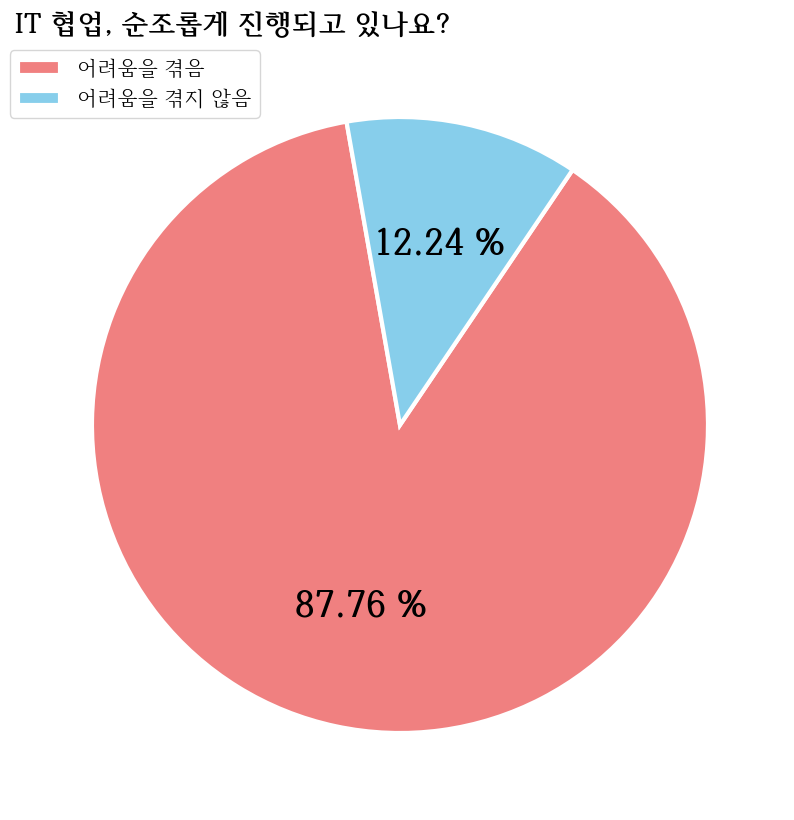

In [91]:
fig, ax = plt.subplots(figsize=(10,10))
df['col1'].value_counts().plot.pie(
    ax=ax, 
    autopct='%1.2f %%',
    textprops={'fontsize': 26, 'fontweight':'bold'},
    startangle=100, 
    colors=['lightcoral', 'skyblue'],  # 색상
    labels=['', ''],  # 라벨 명시
    wedgeprops={'linewidth': 3, 'edgecolor': 'white'},  # 테두리
)
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)

_=ax.legend(
    ['어려움을 겪음', '어려움을 겪지 않음'], 
    loc='upper left', bbox_to_anchor=(-0.02, 1),
    fontsize=15,
)

_=plt.title("IT 협업, 순조롭게 진행되고 있나요?", fontweight='bold', fontsize=20, loc='left')

### 어려움  원인

#### 개발 -> 비개발

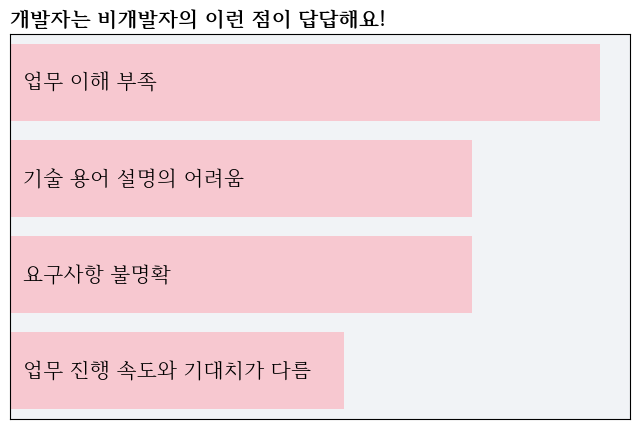

In [70]:
df1 = df.loc[(df['is_dev']!='비개발자')&(df['issues_with_non_dev']!="어려움을 겪지 않는다.")]

l = []

for data in df1['issues_with_non_dev']:
    rvs = data.split(";")
    for rv in rvs:
        l.append(rv) 

df2 = pd.DataFrame({"troubles": l})
order = df2['troubles'].value_counts().index

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df2, y='troubles', order=order, color='pink')
ax.set_facecolor('#F1F3F6')

labels = ['업무 이해 부족', '기술 용어 설명의 어려움', '요구사항 불명확', '업무 진행 속도와 기대치가 다름']

for i, bar in enumerate(ax.patches):
    plt.text(
        0.5,  # X 좌표 
        bar.get_y() + bar.get_height() / 2,  # Y 좌표 (막대 높이의 중앙)
        labels[i],  # 표시할 텍스트
        ha='left', va='center', 
        color='black', fontsize=15
    )

# 그래프 꾸미기
plt.title("개발자는 비개발자의 이런 점이 답답해요!", loc='left', fontweight='bold', fontsize=15)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.show()

#### 비개발 -> 개발

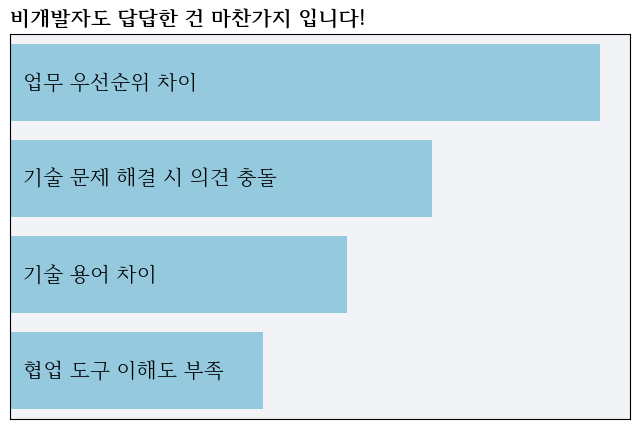

In [75]:
df1 = df.loc[(df['is_dev']=='비개발자')&(df['issues_with_dev']!='어려움을 겪지 않는다.')]

l = []

for data in df1['issues_with_dev']:
    rvs = data.split(";")
    for rv in rvs:
        l.append(rv) 

df2 = pd.DataFrame({"troubles": l})
order = df2['troubles'].value_counts().index

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df2, y='troubles', order=order, color='skyblue')
ax.set_facecolor('#F1F3F6')

labels= ['업무 우선순위 차이','기술 문제 해결 시 의견 충돌','기술 용어 차이','협업 도구 이해도 부족']
for i, bar in enumerate(ax.patches):
    plt.text(
        0.15,  # X 좌표 
        bar.get_y() + bar.get_height() / 2,  # Y 좌표 (막대 높이의 중앙)
        labels[i],  # 표시할 텍스트
        ha='left', va='center', 
        color='black', fontsize=15
    )

# 그래프 꾸미기
plt.title("비개발자도 답답한 건 마찬가지 입니다!", loc='left', fontweight='bold', fontsize=15)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.show()

#### 개발 -> 개발

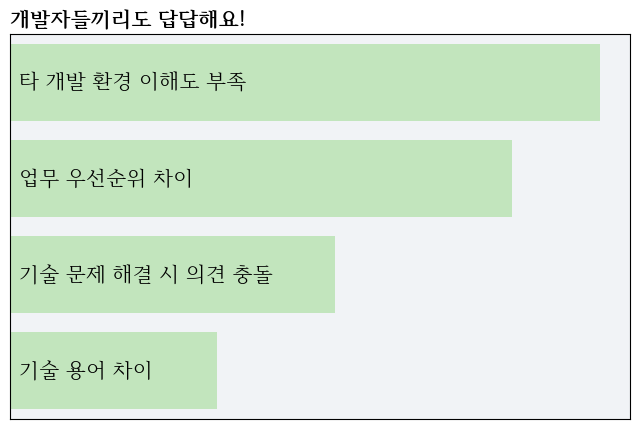

In [71]:
df1 = df.loc[(df['is_dev']!='비개발자')&(~df['issues_with_dev'].str.contains('어려움을 겪지 않는다'))]

l = []

for data in df1['issues_with_dev']:
    rvs = data.split(";")
    for rv in rvs:
        l.append(rv) 

df2 = pd.DataFrame({"troubles": l})

plt.figure(figsize=(8, 5))
order = df2['troubles'].value_counts().index
ax = sns.countplot(data=df2, y='troubles', order=order, color='#BDECB6')
ax.set_facecolor('#F1F3F6')

labels= ['타 개발 환경 이해도 부족','업무 우선순위 차이','기술 문제 해결 시 의견 충돌','기술 용어 차이']
for i, bar in enumerate(ax.patches):
    plt.text(
        0.3,  # X 좌표 
        bar.get_y() + bar.get_height() / 2,  # Y 좌표 (막대 높이의 중앙)
        labels[i],  # 표시할 텍스트
        ha='left', va='center', 
        color='black', fontsize=15
    )

# 그래프 꾸미기
plt.title("개발자들끼리도 답답해요!", loc='left', fontweight='bold', fontsize=15)
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.show()

## WordCloud

In [72]:
def get_WordCloud(df, col, title):
    okt = Okt()

    korean_stopwords = set(get_stopwords(language='korean'))
    custom_stopwords = {
        '이', '그', '저', '것', '나', '너', '우리', '저희', '그들', '그녀', 
        '입니다', '하', '이것', '저것', '다', '되다', '하다', '있다', '없다', 
        '과', '도', '의', '는', '은', '를', '이', '가', '에서', '에', '을',
        '아주','진짜','정말','가장','너무','정말로','대해','대하여','이건','모든','저건','통해',
        '제발','자꾸','계속','이후','부분','완전','그냥','걍','이면','때문','대한','치가','위해','개발','개발자'
    }
    total_stopwords = korean_stopwords.union(custom_stopwords)
    
    
    combined_text = ' '.join(df[col].astype(str))
    
    tokens_ko = okt.nouns(combined_text)
    
    filtered_tokens = [word for word in tokens_ko if word not in total_stopwords and len(word) > 1]

    word_freq = Counter(filtered_tokens)
    
    top_words = word_freq.most_common(100)
    bubble_mask = np.array(Image.open('../../ㅇㅇ/YoonseokChoi.jpg'))
    
    wordcloud = WordCloud(
        font_path=font_path,  # Windows 한글 폰트 경로
        colormap='Pastel1',  # 색상 맵 (색상 팔레트)
        mask = bubble_mask
    ).generate_from_frequencies(dict(top_words))
    
    # 워드 클라우드 출력
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=18, fontweight='bold', loc = 'left')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') 
#     _= plt.tight_layout()
    plt.show()

### 타 직무와의 원활한 소통 방안

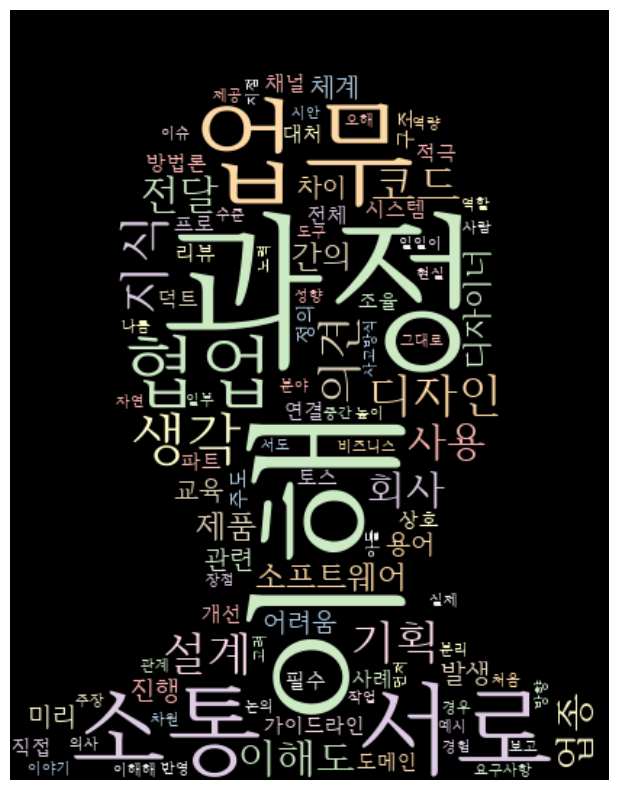

In [73]:
get_WordCloud(df, "com_feedback","")

In [104]:
# df1 = df.loc[df['is_dev']!="비개발자"]
# get_WordCloud(df1, "issues_with_dev", 'test')

In [39]:
# get_WordCloud(df, "issues_with_non_dev", 'test')

## 서비스 사용 희망 여부

### 직무별

In [102]:
df1 = df.assign(roles=df["roles"].str.split(";")).explode("roles")
df1 = round(df1.groupby('roles')['use_service'].value_counts().reset_index(),2)
df1 = df1.sort_values(by = ['roles','use_service'])
df1.columns = ['직무', '서비스 희망 여부', 'COUNT']
df1.reset_index(drop=True)

,직무,서비스 희망 여부,COUNT
0,AI 엔지니어,아니오,2
1,AI 엔지니어,예,3
2,Back-end 개발자,아니오,2
3,Back-end 개발자,예,12
4,DevOps 엔지니어,아니오,2
5,DevOps 엔지니어,예,1
6,Front-end 개발자,아니오,2
7,Front-end 개발자,예,7
8,MLOps 엔지니어,아니오,2
9,MLOps 엔지니어,예,1


In [38]:
# fig, ax = plt.subplots(figsize=(10,5))
# _=sns.barplot(
#     data = df1,
#     x = 'current_roles', y = 'proportion',
#     hue = 'use_service_intent',
#     ax = ax
# )
# _=plt.xticks(rotation=45)

In [29]:
# expanded = (
#     df.assign(current_roles=df["current_roles"].str.split(";"))
#     .explode("current_roles")
# )

# # 직무별 use_service_intent 값 카운트
# result = expanded.groupby(["current_roles", "use_service_intent"]).size().unstack(fill_value=0)

# result['아니오 비율'] = round(result['아니오'] / (result['아니오'] + result['예']),2)
# result['예 비율'] = round(result['예'] / (result['아니오'] + result['예']),2)

# # 결과 확인
# result

### 기업규모별

In [182]:
df1 = round(df.groupby(['company_type'])['use_service'].value_counts(normalize=True).reset_index(),4)
df1 = df1.loc[~df1['company_type'].isin(['프리랜서','대학원'])]
df1.columns = ['기업규모','서비스 사용 희망 여부', '비율(%)']
df1['비율(%)'] = df1['비율(%)']*100 
df1

,기업규모,서비스 사용 희망 여부,비율(%)
0,대기업,예,76.92
1,대기업,아니오,23.08
3,스타트업,예,69.23
4,스타트업,아니오,30.77
5,중견기업,예,71.43
6,중견기업,아니오,28.57
7,중소기업,예,83.33
8,중소기업,아니오,16.67


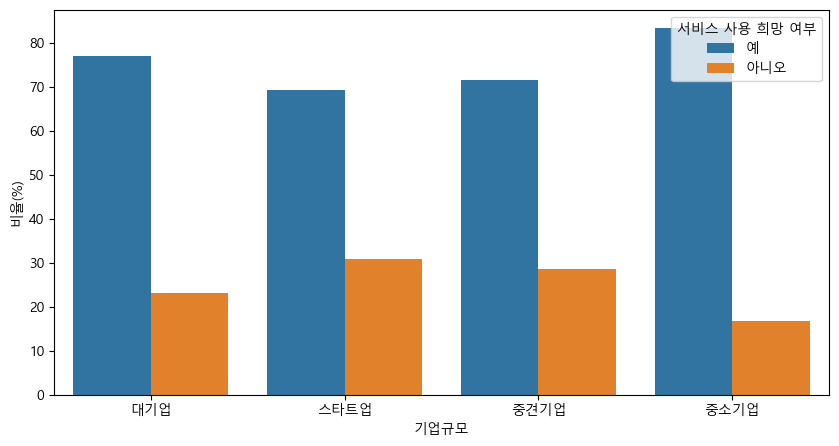

In [144]:
# fig, ax = plt.subplots(figsize=(10,5))
# _=sns.barplot(
#     data = df1,
#     x = '기업규모', y = '비율(%)',
#     hue = '서비스 사용 희망 여부',
#     ax = ax
# )
# _=plt.xticks(rotation=0)

### IT / 비IT

In [103]:
df1 = df.groupby(['is_IT'])['use_service'].value_counts(normalize=True).reset_index()
df1 = df1.sort_values(by=['is_IT', 'use_service'], ascending=False).reset_index(drop=True)
df1 = round(df1, 4)
df1.columns = ['IT 기업 여부', '서비스 사용 희망', '비율(%)']
df1['비율(%)'] = df1['비율(%)']*100 
df1

,IT 기업 여부,서비스 사용 희망,비율(%)
0,예,예,70.00
1,예,아니오,30.00
2,아니오,예,77.78
3,아니오,아니오,22.22


### 성별

In [184]:
df1 = df.groupby(['gender'])['use_service'].value_counts(normalize=True).reset_index()
df1 = df1.sort_values(by=['gender', 'use_service'], ascending=[True, False]).reset_index(drop=True)
df1 = round(df1, 4)
df1.columns = ['성별', '서비스 이용 희망', '비율(%)']
df1['비율(%)'] = df1['비율(%)']*100 
df1

,성별,서비스 이용 희망,비율(%)
0,남성,예,74.07
1,남성,아니오,25.93
2,여성,예,68.18
3,여성,아니오,31.82


### 연차별

In [183]:
df1 = df.groupby(['experience'])['use_service'].value_counts(normalize=True).reset_index()
df1 = df1.sort_values(by=['experience', 'use_service'], ascending=[True,False]).reset_index(drop=True)
df1 = round(df1, 4)
df1.columns = ['경력', '서비스 이용 희망', '비율(%)']
df1['비율(%)'] = df1['비율(%)']*100 
df1

,경력,서비스 이용 희망,비율(%)
0,1년 미만,예,80.95
1,1년 미만,아니오,19.05
2,1년~3년,예,71.43
3,1년~3년,아니오,28.57
4,3년~5년,예,50.00
5,3년~5년,아니오,50.00
6,5년 이상,예,33.33
7,5년 이상,아니오,66.67
